# Retrieval performance under cloudy conditions without cloud correction

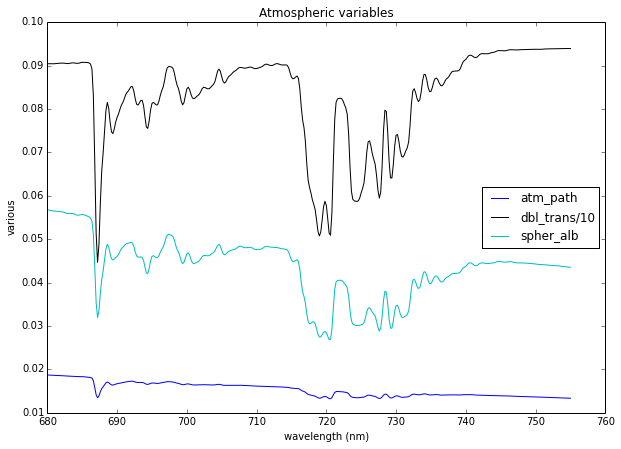

In [1]:
import numpy as np
from scipy.interpolate import interp1d
import pickle
import matplotlib.pylab as plt
%matplotlib inline


# dictionary file
fn = '/home/malapradej/Documents/PhD_UCL/Data/LUT/lut_southampton_presentation/quick_clds_dasf/20/0/0/0.0_0.1_20_1013.p'
sza = int(fn.split('/')[-4])
vza = int(fn.split('/')[-3])
raa = int(fn.split('/')[-2])
sol_zen = sza
sat_zen = vza
rel_azi = raa

dic = pickle.load(open(fn, 'rb'))

# to range we need
wl_min = 680
wl_max = 755
#ixs = np.logical_and(dic['lam']>=wl_min, dic['lam']<=wl_max)
lam = dic['lam'] #[ixs]
atm_path = dic['atm_path'] #[ixs]
dbl_trans = dic['dbl_trans'] #[ixs]
spher_alb = dic['spher_alb'] #[ixs]
WVC = dic['WVC']
AOT = dic['AOT']
press = dic['press']
alt = dic['alt']

# get wavelenght interval to approximately GOME-2 resolution
resol = 0.2 # in nm
lam_gome = np.arange(wl_min, wl_max+0.001, resol)

atm_path = (interp1d(lam, atm_path, kind='linear'))(lam_gome)
dbl_trans = (interp1d(lam, dbl_trans, kind='linear'))(lam_gome)
spher_alb = (interp1d(lam, spher_alb, kind='linear'))(lam_gome)

lam = lam_gome
lam = np.round(lam, 1) # stops the interpolation error due to precision fault

plt.figure(figsize=(10,7))
plt.plot(lam, atm_path, 'b-', label='atm_path')
plt.plot(lam, dbl_trans/10, 'k-', label='dbl_trans/10')
plt.plot(lam, spher_alb, 'c-', label='spher_alb')
plt.title('Atmospheric variables')
plt.ylabel('various')
plt.xlabel('wavelength (nm)')
plt.legend(loc='best')
plt.show()

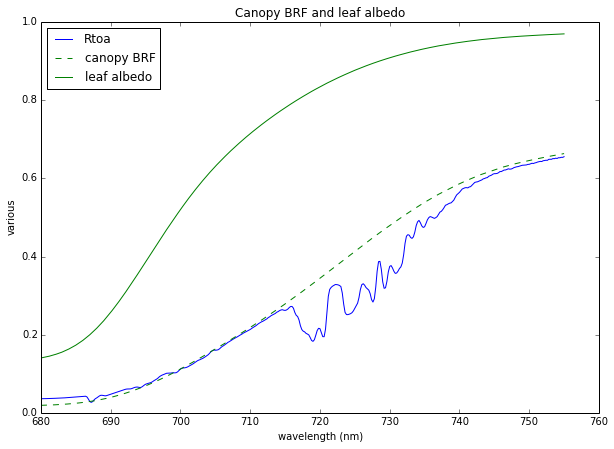

In [2]:
# simply simulate a canopy, leaf and TOA signal without clouds.

# leaf data
fn = 'leaf_spectrum.txt'
leaf = np.loadtxt(fn).T
leafLambda = leaf[0]
leafAlbedo = leaf[1] + leaf[2]

# reduce the leaf lam and albedo data size (speeds up interpolation...)
#xleafFull = leafLambda
#leafLambda = xleafFull[(xleafFull>=wl_min) * (xleafFull<=wl_max)]
#leafAlbedo = leafAlbedo[(xleafFull>=wl_min) * (xleafFull<=wl_max)]

from scipy.interpolate import interp1d

func = interp1d(leafLambda, leafAlbedo, kind='linear')
leaf = func(lam)

# fixed canopy parameters
a = 0.12
p = 0.85
BRF = a*leaf / (1 - p*leaf)

# forward model without clouds
Rtoa = atm_path + BRF*dbl_trans / (1 - spher_alb*BRF)

# adding noise to the data
snr = 1000. # signal to noise ratio 2000 from Guanter et al 2014, and 1000 from Joiner 2014, Paris

# add the uncorrelated noise
# use convention of SNR = expected signal / std of noise
std_noise = Rtoa / snr
rand_noise = np.random.normal(0., std_noise)
Rtoa += rand_noise

plt.figure(figsize=(10,7))
plt.plot(lam, Rtoa, 'b-', label='Rtoa')
plt.plot(lam, BRF, 'g--', label='canopy BRF')
plt.plot(lam, leaf, 'g-', label='leaf albedo')
plt.title('Canopy BRF and leaf albedo')
plt.ylabel('various')
plt.xlabel('wavelength (nm)')
plt.legend(loc=0)


In [3]:
# seeing if we can retrieve a and p with other parameters fixed

def Rtoa_no_cld(a, p, atm_path, dbl_trans, spher_alb, leaf):
    R = atm_path + dbl_trans * (a*leaf/(1 - p*leaf)) / (1 - spher_alb*(a*leaf/(1 - p*leaf)))
    return R

def cost(ap, atm_path, dbl_trans, spher_alb, leaf, Rtoa):
    a = ap[0]
    p = ap[1]
    resid = Rtoa_no_cld(a, p, atm_path, dbl_trans, spher_alb, leaf) - Rtoa
    return np.sum(resid**2)

from scipy.optimize import fmin_bfgs

ap = (0.9, 0.1)
args = (atm_path, dbl_trans, spher_alb, leaf, Rtoa)

result = fmin_bfgs(cost, x0=ap, args=args)
print result

Optimization terminated successfully.
         Current function value: 0.000048
         Iterations: 19
         Function evaluations: 164
         Gradient evaluations: 41
[ 0.1200588   0.84989306]


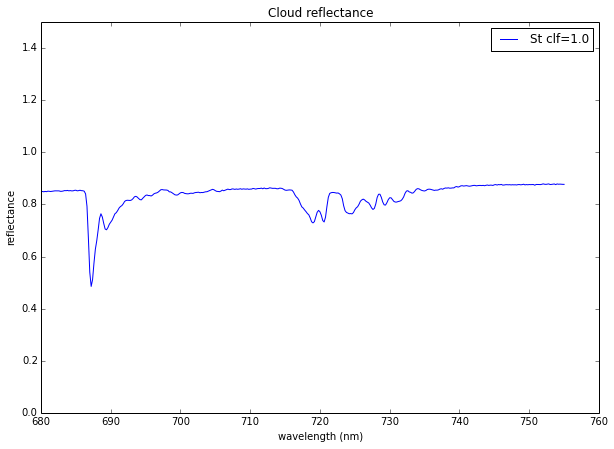

In [4]:
# adding clouds
import pandas as pd
fn = 'cloud_sims.h5'
cld_type = 'St'
cld_df = pd.read_hdf(fn, key='reflectance')
cld_lam = cld_df[cld_type].icol(0).index.values
cld_ref = cld_df[cld_type].icol(0).values

#interpolate to lam
func = interp1d(cld_lam, cld_ref, kind='linear')
cld_ref = func(lam)

# add the uncorrelated noise
# use convention of SNR = expected signal / std of noise
std_noise = cld_ref / snr
rand_noise = np.random.normal(0., std_noise)
cld_ref += rand_noise

plt.figure(figsize=(10,7))
plt.plot(lam, cld_ref, 'b-', label='%s clf=1.0' %cld_type)
plt.title('Cloud reflectance')
plt.ylabel('reflectance')
plt.xlabel('wavelength (nm)')
plt.ylim(0.0, 1.5)
plt.legend(loc=0)

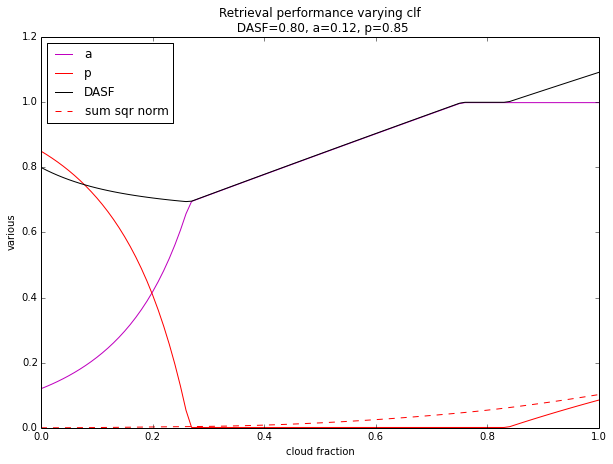

In [5]:
# gradually adding cloud cover and retrieve parameters as we go, see where it falls apart

def Rtoa_clds(a, p, atm_path, dbl_trans, spher_alb, leaf, clf, cld_ref):
    R = (1-clf)*(atm_path + dbl_trans * (a*leaf/(1 - p*leaf)) / (1 - spher_alb*(a*leaf/(1 - p*leaf)))) + clf*cld_ref
    return R

def cost(ap, atm_path, dbl_trans, spher_alb, leaf, Rtoa):
    a = ap[0]
    p = ap[1]
    resid = Rtoa_no_cld(a, p, atm_path, dbl_trans, spher_alb, leaf) - Rtoa
    return np.sum(resid**2)

ap = (0.12, 0.85)
bounds = np.array([(0.001,0.999),(0.001,0.999)])

clfs = np.linspace(0, 1, 101, endpoint=True)

from scipy.optimize import fmin_l_bfgs_b

ass = []
pss = []
DASFs = []
sum_sqr = []

for clf in clfs:
    Rtoa_c = Rtoa_clds(a, p, atm_path, dbl_trans, spher_alb, leaf, clf, cld_ref)
    args = (atm_path, dbl_trans, spher_alb, leaf, Rtoa_c)
    result = fmin_l_bfgs_b(cost, x0=ap, args=args, approx_grad=True, bounds=bounds)
    ass.append(result[0][0])
    pss.append(result[0][1])
    DASFs.append(result[0][0]/(1 - result[0][1]))
    sum_sqr.append(result[1])

plt.figure(figsize=(10,7))
plt.plot(clfs, ass, 'm-', label='a')
plt.plot(clfs, pss, 'r-', label='p')
plt.plot(clfs, DASFs, 'k-', label='DASF')
plt.plot(clfs, np.array(sum_sqr)/len(lam), 'r--', label='sum sqr norm')
plt.legend(loc=0)
plt.title('Retrieval performance varying clf\n DASF=%.2f, a=%.2f, p=%.2f' % (a/(1-p),a,p))
plt.xlabel('cloud fraction')
plt.ylabel('various')

In [6]:
# at 10% clf which is what Philipp Kohler uses
mask = np.where(clfs==0.1)[0]
print 'Values at 10%% clf are for a %.3f for p %.3f and DASF %.3f' %(ass[mask], pss[mask], DASFs[mask])
print 'This is a difference wrt true values of for a %.0f%% and p %.0f%% and DASF %.0f%%' %((ass[mask]-a)*100, (pss[mask]-p)*100, (DASFs[mask]-(a/(1-p)))*100)

Values at 10% clf are for a 0.216 for p 0.706 and DASF 0.737
This is a difference wrt true values of for a 10% and p -14% and DASF -6%


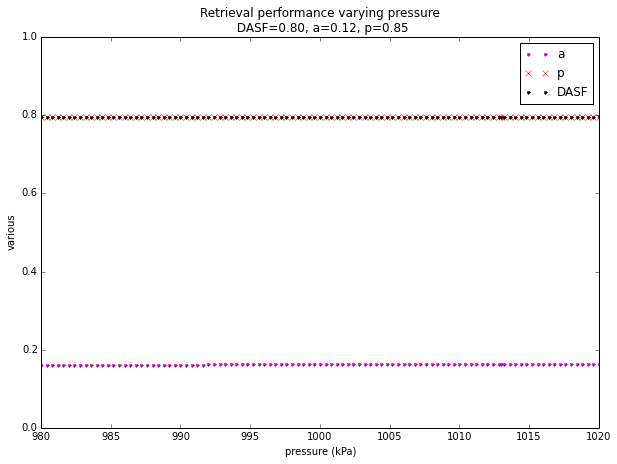

In [7]:
# to test changing pressure on the retrieval of a, p and DASF
import glob
import cPickle
root = '/home/malapradej/Documents/PhD_UCL/Data/LUT/lut_southampton_presentation/quick_atm_DASF/20.0000/0.0000/0.0000/'
fixed_paras = {'sol_zen':'20.0000', 'sat_zen':'0.0000', 'rel_azi':'0.0000', 'alt':'0.0000', 'aot':'0.1000', 'wvc':'20.0000', 'press':'1013.0000'}
regex = root+fixed_paras['alt']+'_'+fixed_paras['aot']+'_'+fixed_paras['wvc']+'_'+'*'+'.p'
paths = sorted(glob.glob(regex))

def Rtoa_atm(a, p, atm_path, dbl_trans, spher_alb, leaf):
    R = atm_path + dbl_trans * (a*leaf/(1 - p*leaf)) / (1 - spher_alb*(a*leaf/(1 - p*leaf)))
    return R

def cost(ap, atm_path, dbl_trans, spher_alb, leaf, BRF):
    a = ap[0]
    p = ap[1]
    resid = Rtoa_atm(a, p, atm_path, dbl_trans, spher_alb, leaf) - BRF
    return np.sum(resid**2)

ass = []
pss = []
DASFs = []
presss = []
for path in paths:
    dic = cPickle.load(open(path, 'rb'))
    alt = dic['alt']
    aot = dic['AOT']
    wvc = dic['WVC']
    press = dic['press']
    atm_path = dic['atm_path'] #[np.logical_and(dic['lam']>=wl_min, dic['lam']<=wl_max)]
    dbl_trans = dic['dbl_trans'] #[np.logical_and(dic['lam']>=wl_min, dic['lam']<=wl_max)]
    spher_alb = dic['spher_alb'] #[np.logical_and(dic['lam']>=wl_min, dic['lam']<=wl_max)]
    lam_ = dic['lam']
    atm_path = (interp1d(lam_, atm_path, kind='linear'))(lam)
    dbl_trans = (interp1d(lam_, dbl_trans, kind='linear'))(lam)
    spher_alb = (interp1d(lam_, spher_alb, kind='linear'))(lam)
    # seeing if we can retrieve a and p with other parameters fixed
    ap = (0.12, 0.85)
    args = (atm_path, dbl_trans, spher_alb, leaf, BRF)
    result = fmin_l_bfgs_b(cost, x0=ap, args=args, approx_grad=True, bounds=bounds)
    ass.append(result[0][0])
    pss.append(result[0][1])
    DASFs.append(result[0][0] / (1 - result[0][1]))
    presss.append(press)

plt.figure(figsize=(10,7))
plt.plot(presss, ass, 'm.', label='a')
plt.plot(presss, pss, 'rx', label='p')
plt.plot(presss, DASFs, 'k.', label='DASF')
plt.ylim(0,1)
plt.legend(loc=0)
plt.title('Retrieval performance varying pressure\n DASF=%.2f, a=%.2f, p=%.2f' % (a/(1-p),a,p))
plt.xlabel('pressure (kPa)')
plt.ylabel('various')

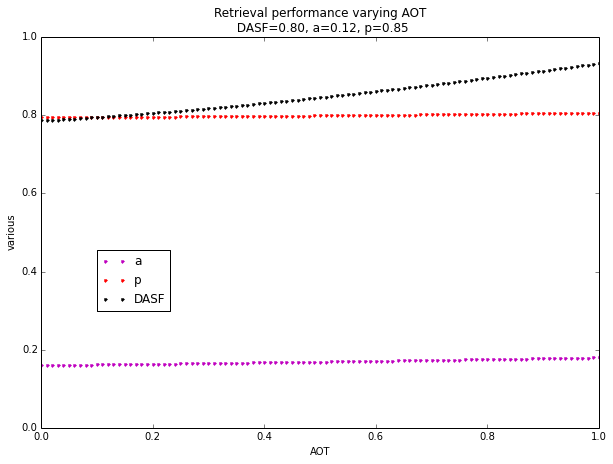

In [8]:
# to test changing aot on the retrieval of a, p and DASF
import glob
import cPickle
root = '/home/malapradej/Documents/PhD_UCL/Data/LUT/lut_southampton_presentation/quick_atm_DASF/20.0000/0.0000/0.0000/'
fixed_paras = {'sol_zen':'20.0000', 'sat_zen':'0.0000', 'rel_azi':'0.0000', 'alt':'0.0000', 'aot':'0.1000', 'wvc':'20.0000', 'press':'1013.0000'}
regex = root+fixed_paras['alt']+'_'+'*'+'_'+fixed_paras['wvc']+'_'+fixed_paras['press']+'.p'
paths = sorted(glob.glob(regex))

def Rtoa_atm(a, p, atm_path, dbl_trans, spher_alb, leaf):
    R = atm_path + dbl_trans * (a*leaf/(1 - p*leaf)) / (1 - spher_alb*(a*leaf/(1 - p*leaf)))
    return R

def cost(ap, atm_path, dbl_trans, spher_alb, leaf, BRF):
    a = ap[0]
    p = ap[1]
    resid = Rtoa_atm(a, p, atm_path, dbl_trans, spher_alb, leaf) - BRF
    return np.sum(resid**2)

ass = []
pss = []
DASFs = []
aots = []
for path in paths:
    dic = cPickle.load(open(path, 'rb'))
    alt = dic['alt']
    aot = dic['AOT']
    wvc = dic['WVC']
    press = dic['press']
    atm_path = dic['atm_path'] #[np.logical_and(dic['lam']>=wl_min, dic['lam']<=wl_max)]
    dbl_trans = dic['dbl_trans'] #[np.logical_and(dic['lam']>=wl_min, dic['lam']<=wl_max)]
    spher_alb = dic['spher_alb'] #[np.logical_and(dic['lam']>=wl_min, dic['lam']<=wl_max)]
    lam_ = dic['lam']
    atm_path = (interp1d(lam_, atm_path, kind='linear'))(lam)
    dbl_trans = (interp1d(lam_, dbl_trans, kind='linear'))(lam)
    spher_alb = (interp1d(lam_, spher_alb, kind='linear'))(lam)
    # seeing if we can retrieve a and p with other parameters fixed
    # seeing if we can retrieve a and p with other parameters fixed
    ap = (0.1, 0.9)
    args = (atm_path, dbl_trans, spher_alb, leaf, BRF)
    result = fmin_l_bfgs_b(cost, x0=ap, args=args, approx_grad=True, bounds=bounds)
    ass.append(result[0][0])
    pss.append(result[0][1])
    DASFs.append(result[0][0] / (1 - result[0][1]))
    aots.append(aot)

plt.figure(figsize=(10,7))
plt.plot(aots, ass, 'm.', label='a')
plt.plot(aots, pss, 'r.', label='p')
plt.plot(aots, DASFs, 'k.', label='DASF')
plt.ylim(0,)
plt.legend(loc=(0.1, 0.3))
plt.title('Retrieval performance varying AOT\n DASF=%.2f, a=%.2f, p=%.2f' % (a/(1-p),a,p))
plt.xlabel('AOT')
plt.ylabel('various')


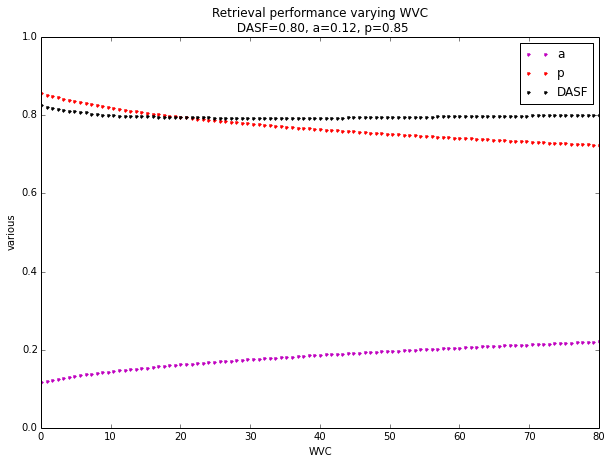

In [9]:
# to test changing wvc on the retrieval of a, p and DASF
import glob
import cPickle
root = '/home/malapradej/Documents/PhD_UCL/Data/LUT/lut_southampton_presentation/quick_atm_DASF/20.0000/0.0000/0.0000/'
fixed_paras = {'sol_zen':'20.0000', 'sat_zen':'0.0000', 'rel_azi':'0.0000', 'alt':'0.0000', 'aot':'0.1000', 'wvc':'20.0000', 'press':'1013.0000'}
regex = root+fixed_paras['alt']+'_'+fixed_paras['aot']+'_'+'*'+'_'+fixed_paras['press']+'.p'
paths = sorted(glob.glob(regex))

def Rtoa_atm(a, p, atm_path, dbl_trans, spher_alb, leaf):
    R = atm_path + dbl_trans * (a*leaf/(1 - p*leaf)) / (1 - spher_alb*(a*leaf/(1 - p*leaf)))
    return R

def cost(ap, atm_path, dbl_trans, spher_alb, leaf, BRF):
    a = ap[0]
    p = ap[1]
    resid = Rtoa_atm(a, p, atm_path, dbl_trans, spher_alb, leaf) - BRF
    return np.sum(resid**2)

ass = []
pss = []
DASFs = []
wvcs = []
for path in paths:
    dic = cPickle.load(open(path, 'rb'))
    alt = dic['alt']
    aot = dic['AOT']
    wvc = dic['WVC']
    press = dic['press']
    atm_path = dic['atm_path'] #[np.logical_and(dic['lam']>=wl_min, dic['lam']<=wl_max)]
    dbl_trans = dic['dbl_trans'] #[np.logical_and(dic['lam']>=wl_min, dic['lam']<=wl_max)]
    spher_alb = dic['spher_alb'] #[np.logical_and(dic['lam']>=wl_min, dic['lam']<=wl_max)]
    lam_ = dic['lam']
    atm_path = (interp1d(lam_, atm_path, kind='linear'))(lam)
    dbl_trans = (interp1d(lam_, dbl_trans, kind='linear'))(lam)
    spher_alb = (interp1d(lam_, spher_alb, kind='linear'))(lam)
    # seeing if we can retrieve a and p with other parameters fixed
    ap = (0.1, 0.9)
    args = (atm_path, dbl_trans, spher_alb, leaf, BRF)
    result = fmin_l_bfgs_b(cost, x0=ap, args=args, approx_grad=True, bounds=bounds)
    ass.append(result[0][0])
    pss.append(result[0][1])
    DASFs.append(result[0][0] / (1 - result[0][1]))
    wvcs.append(wvc)

plt.figure(figsize=(10,7))
plt.plot(wvcs, ass, 'm.', label='a')
plt.plot(wvcs, pss, 'r.', label='p')
plt.plot(wvcs, DASFs, 'k.', label='DASF')
plt.ylim(0,1)
plt.legend(loc=0)
plt.title('Retrieval performance varying WVC\n DASF=%.2f, a=%.2f, p=%.2f' % (a/(1-p),a,p))
plt.xlabel('WVC')
plt.ylabel('various')


# Retrieval performance under cloudy conditions with cloud correction

In [10]:
# import cloud PCA
h5_fn = 'cloud_sims.h5'
pca_red_df = pd.read_hdf(h5_fn, key='pca_red_edge')

pca_lam = np.array(pca_red_df.index)
pcas_ = pca_red_df.values.T

# interpolate to gome resolution
pcas = []
for pc in pcas_:
    pcas.append((interp1d(pca_lam, pc, kind='linear'))(lam))
pcas = np.array(pcas)

## with one PC

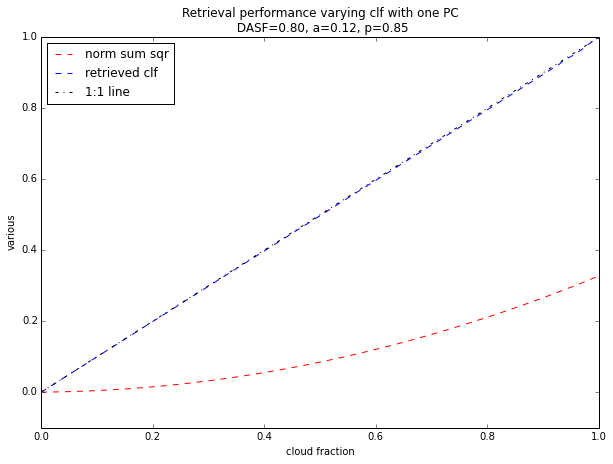

In [11]:
# keep other parameters fixed and only retrieve clf

def Rtoa_clds(a, p, atm_path, dbl_trans, spher_alb, leaf, clf, cld_ref):
    R = (1-clf)*(atm_path + dbl_trans * (a*leaf/(1 - p*leaf)) / (1 - spher_alb*(a*leaf/(1 - p*leaf)))) + clf*cld_ref
    return R

def Rtoa_cld_corr(a, p, a0_n, atm_path, dbl_trans, spher_alb, leaf, pcas):
    X = atm_path + dbl_trans * (a*leaf/(1 - p*leaf)) / (1 - spher_alb*(a*leaf/(1 - p*leaf)))
    a0 = a0_n[0]
    a1 = a0_n[1]
    R = 1. / a0 * (X - a1 * pcas[0])
    return R

def cost(pars, a, p, atm_path, dbl_trans, spher_alb, leaf, Rtoa, pcas):
    a0_n = pars
    resid = Rtoa_cld_corr(a, p, a0_n, atm_path, dbl_trans, spher_alb, leaf, pcas) - Rtoa
    return np.sum(resid**2)

bounds = np.array([(1.,1000),(0,10000)])

clfs = np.linspace(0, 1, 101, endpoint=True)

from scipy.optimize import fmin_tnc #fmin_l_bfgs_b

ass = []
pss = []
clf_r = []
coes = []
DASFs = []
sum_sqr = []

for clf in clfs:
    a = 0.12
    p = 0.85
    a0_n = (1./(1. - clf), -30.*clf/(1.-clf))
    Rtoa_c = Rtoa_clds(a, p, atm_path, dbl_trans, spher_alb, leaf, clf, cld_ref)
    args = (a, p, atm_path, dbl_trans, spher_alb, leaf, Rtoa_c, pcas)
    result = fmin_tnc(cost, x0=a0_n, args=args, approx_grad=True, bounds=bounds)
    pars = result[0]
    clf_r.append((pars[0]-1.)/pars[0])
    coes.append(pars[1])
    sum_sqr.append(cost(pars, a, p, atm_path, dbl_trans, spher_alb, leaf, Rtoa, pcas)/len(lam))
    #print clf,(pars[0]-1.)/pars[0], pars, cost(pars, a, p, atm_path, dbl_trans, spher_alb, leaf, Rtoa, pcas)/len(lam)

plt.figure(figsize=(10,7))
plt.plot(clfs, sum_sqr, 'r--', label='norm sum sqr')
plt.plot(clfs, clf_r, 'b--', label='retrieved clf')
plt.plot((0.,1.), (0.,1.), 'k-.', label='1:1 line')
plt.legend(loc=0)
plt.ylim(-.1, 1.)
plt.title('Retrieval performance varying clf with one PC\n DASF=%.2f, a=%.2f, p=%.2f' % (a/(1-p),a,p))
plt.xlabel('cloud fraction')
plt.ylabel('various')

In [12]:
sum_sqr[50]

0.085044913487372406

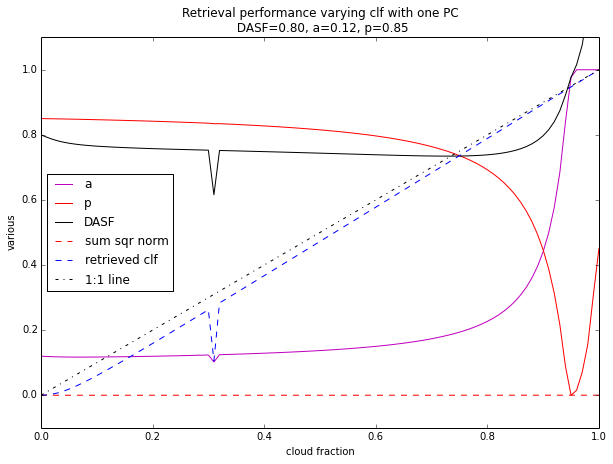

In [13]:
# gradually adding cloud cover and correcting for it as a retrieve parameters as we go, see where it falls apart

def Rtoa_clds(a, p, atm_path, dbl_trans, spher_alb, leaf, clf, cld_ref):
    R = (1-clf)*(atm_path + dbl_trans * (a*leaf/(1 - p*leaf)) / (1 - spher_alb*(a*leaf/(1 - p*leaf)))) + clf*cld_ref
    return R

def Rtoa_cld_corr(a, p, a0_, atm_path, dbl_trans, spher_alb, leaf, pcas):
    X = atm_path + dbl_trans * (a*leaf/(1 - p*leaf)) / (1 - spher_alb*(a*leaf/(1 - p*leaf)))
    a0 = a0_[0]
    a1 = a0_[1]
    R = 1. / a0 * (X - a1 * pcas[0])
    return R

def cost(apa0, atm_path, dbl_trans, spher_alb, leaf, Rtoa, pcas):
    a = apa0[0]
    p = apa0[1]
    a0_ = apa0[2:]
    resid = Rtoa_cld_corr(a, p, a0_, atm_path, dbl_trans, spher_alb, leaf, pcas) - Rtoa
    return np.sum(resid**2)

bounds = np.array([(0.00,1.00),(0.00,1.00),(1.,1000.),(0.,10000.)])

clfs = np.linspace(0, 1, 101, endpoint=True)

from scipy.optimize import fmin_l_bfgs_b

ass = []
pss = []
clf_r = []
coes = []
DASFs = []
sum_sqr = []

for clf in clfs:
    apa0 = (0.12, 0.85, 1./(1. - clf), 30.*clf/(1.-clf))
    Rtoa_c = Rtoa_clds(a, p, atm_path, dbl_trans, spher_alb, leaf, clf, cld_ref)
    args = (atm_path, dbl_trans, spher_alb, leaf, Rtoa_c, pcas)
    result = fmin_l_bfgs_b(cost, x0=apa0, args=args, approx_grad=True, bounds=bounds)
    pars = result[0]
    ass.append(pars[0])
    pss.append(pars[1])
    DASFs.append(pars[0]/(1 - pars[1]))
    clf_r.append((pars[2]-1.)/pars[2])
    coes.append(pars[3])
    sum_sqr.append(result[1])
    #print pars, result[1]

plt.figure(figsize=(10,7))
plt.plot(clfs, ass, 'm-', label='a')
plt.plot(clfs, pss, 'r-', label='p')
plt.plot(clfs, DASFs, 'k-', label='DASF')
plt.plot(clfs, np.array(sum_sqr)/len(lam), 'r--', label='sum sqr norm')
plt.plot(clfs, clf_r, 'b--', label='retrieved clf')
plt.plot((0.,1.), (0.,1.), 'k-.', label='1:1 line')
plt.legend(loc=0)
plt.ylim(-.1, 1.1)
plt.title('Retrieval performance varying clf with one PC\n DASF=%.2f, a=%.2f, p=%.2f' % (a/(1-p),a,p))
plt.xlabel('cloud fraction')
plt.ylabel('various')

In [14]:
# at 10% clf which is what Philipp Kohler uses
thresh = .1
mask = np.where(clfs==thresh)[0]
print 'Values at %d%% clf are for a %.3f for p %.3f and DASF %.3f' %(thresh*100, ass[mask], pss[mask], DASFs[mask])
print 'This is a difference wrt true values of for a %.0f%% and p %.0f%% and DASF %.0f%%' %((ass[mask]-a)*100, (pss[mask]-p)*100, (DASFs[mask]-(a/(1-p)))*100)

Values at 10% clf are for a 0.117 for p 0.847 and DASF 0.765
This is a difference wrt true values of for a -0% and p -0% and DASF -3%


In [15]:
thresh = .2
mask = np.where(clfs==thresh)[0]
print 'Values at %d%% clf are for a %.3f for p %.3f and DASF %.3f' %(thresh*100, ass[mask], pss[mask], DASFs[mask])
print 'This is a difference wrt true values of for a %.0f%% and p %.0f%% and DASF %.0f%%' %((ass[mask]-a)*100, (pss[mask]-p)*100, (DASFs[mask]-(a/(1-p)))*100)

Values at 20% clf are for a 0.120 for p 0.842 and DASF 0.758
This is a difference wrt true values of for a -0% and p -1% and DASF -4%


In [16]:
thresh = .3
mask = np.where(clfs==thresh)[0]
print 'Values at %d%% clf are for a %.3f for p %.3f and DASF %.3f' %(thresh*100, ass[mask], pss[mask], DASFs[mask])
print 'This is a difference wrt true values of for a %.0f%% and p %.0f%% and DASF %.0f%%' %((ass[mask]-a)*100, (pss[mask]-p)*100, (DASFs[mask]-(a/(1-p)))*100)

Values at 30% clf are for a 0.124 for p 0.836 and DASF 0.753
This is a difference wrt true values of for a 0% and p -1% and DASF -5%


In [17]:
thresh = .4
mask = np.where(clfs==thresh)[0]
print 'Values at %d%% clf are for a %.3f for p %.3f and DASF %.3f' %(thresh*100, ass[mask], pss[mask], DASFs[mask])
print 'This is a difference wrt true values of for a %.0f%% and p %.0f%% and DASF %.0f%%' %((ass[mask]-a)*100, (pss[mask]-p)*100, (DASFs[mask]-(a/(1-p)))*100)

Values at 40% clf are for a 0.129 for p 0.827 and DASF 0.748
This is a difference wrt true values of for a 1% and p -2% and DASF -5%


# with several PCs

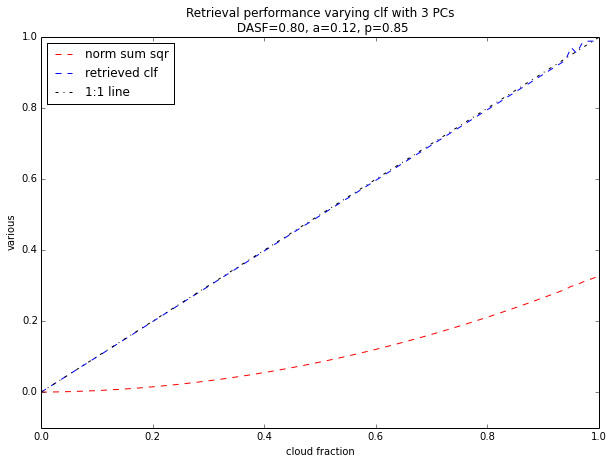

In [18]:
# adding more PCs and keeping a, p and atmospheric parameters fixed.

def Rtoa_clds(a, p, atm_path, dbl_trans, spher_alb, leaf, clf, cld_ref):
    R = (1-clf)*(atm_path + dbl_trans * (a*leaf/(1 - p*leaf)) / (1 - spher_alb*(a*leaf/(1 - p*leaf)))) + clf*cld_ref
    return R

def Rtoa_cld_corr(a, p, a0_n, atm_path, dbl_trans, spher_alb, leaf, pcas):
    X = atm_path + dbl_trans * (a*leaf/(1 - p*leaf)) / (1 - spher_alb*(a*leaf/(1 - p*leaf)))
    a0 = a0_n[0]
    a1 = a0_n[1]
    a2 = a0_n[2]
    a3 = a0_n[3]
    R = 1. / a0 * (X - a1 * pcas[0] - a2 * pcas[1] - a3 * pcas[2])
    return R

def cost(pars, a, p, atm_path, dbl_trans, spher_alb, leaf, Rtoa, pcas):
    a0_n = pars
    resid = Rtoa_cld_corr(a, p, a0_n, atm_path, dbl_trans, spher_alb, leaf, pcas) - Rtoa
    return np.sum(resid**2)

bounds = np.array([(1.,10000),(0,1000000),(0,10000),(0,1000)])

clfs = np.linspace(0, 1, 101, endpoint=True)

from scipy.optimize import fmin_tnc #fmin_l_bfgs_b

ass = []
pss = []
clf_r = []
coes = []
DASFs = []
sum_sqr = []

for clf in clfs:
    a = 0.12
    p = 0.85
    a0_n = (1./(1. - clf), clf/(1.-clf), clf/(1.-clf), clf/(1.-clf))
    Rtoa_c = Rtoa_clds(a, p, atm_path, dbl_trans, spher_alb, leaf, clf, cld_ref)
    args = (a, p, atm_path, dbl_trans, spher_alb, leaf, Rtoa_c, pcas)
    result = fmin_tnc(cost, x0=a0_n, args=args, approx_grad=True, bounds=bounds)
    pars = result[0]
    clf_r.append((pars[0]-1.)/pars[0])
    coes.append(pars[1])
    sum_sqr.append(cost(pars, a, p, atm_path, dbl_trans, spher_alb, leaf, Rtoa, pcas)/len(lam))
    #print clf,(pars[0]-1.)/pars[0], pars, cost(pars, a, p, atm_path, dbl_trans, spher_alb, leaf, Rtoa, pcas)/len(lam)

plt.figure(figsize=(10,7))
plt.plot(clfs, sum_sqr, 'r--', label='norm sum sqr')
plt.plot(clfs, clf_r, 'b--', label='retrieved clf')
plt.plot((0.,1.), (0.,1.), 'k-.', label='1:1 line')
plt.legend(loc=0)
plt.ylim(-.1, 1.)
plt.title('Retrieval performance varying clf with %d PCs\n DASF=%.2f, a=%.2f, p=%.2f' % (len(bounds)-1,a/(1-p),a,p))
plt.xlabel('cloud fraction')
plt.ylabel('various')

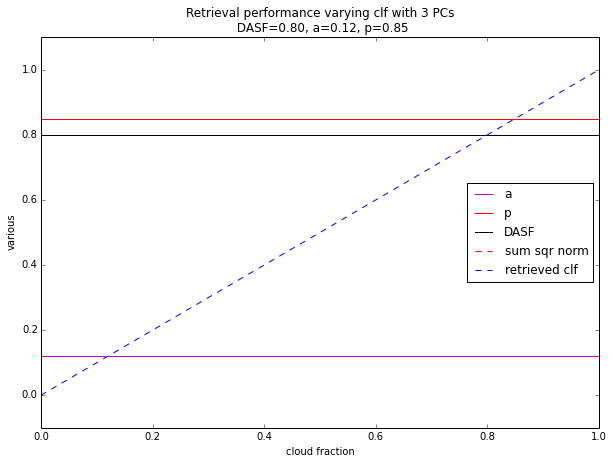

In [19]:
# adding more PCs and keeping only atmospheric parameters fixed

def Rtoa_clds(a, p, atm_path, dbl_trans, spher_alb, leaf, clf, cld_ref):
    R = (1-clf)*(atm_path + dbl_trans * (a*leaf/(1 - p*leaf)) / (1 - spher_alb*(a*leaf/(1 - p*leaf)))) + clf*cld_ref
    return R

def Rtoa_cld_corr(a, p, a0_, atm_path, dbl_trans, spher_alb, leaf, pcas):
    X = atm_path + dbl_trans * (a*leaf/(1 - p*leaf)) / (1 - spher_alb*(a*leaf/(1 - p*leaf)))
    a0 = a0_[0]
    a1 = a0_[1]
    a2 = a0_n[2]
    a3 = a0_n[3]
    R = 1. / a0 * (X - a1 * pcas[0] - a2 * pcas[1] - a3 * pcas[2])
    return R

def cost(apa0, atm_path, dbl_trans, spher_alb, leaf, Rtoa, pcas):
    a = apa0[0]
    p = apa0[1]
    a0_ = apa0[2:]
    resid = Rtoa_cld_corr(a, p, a0_, atm_path, dbl_trans, spher_alb, leaf, pcas) - Rtoa
    return np.sum(resid**2)

bounds = np.array([(0.00,1.00),(0.00,1.00),(1.,10000),(0,1000000),(0,10000),(0,1000)])

clfs = np.linspace(0, 1, 101, endpoint=True)

from scipy.optimize import fmin_l_bfgs_b

ass = []
pss = []
clf_r = []
coes = []
DASFs = []
sum_sqr = []

for clf in clfs:
    apa0 = (0.12, 0.85, 1./(1. - clf), clf/(1.-clf), clf/(1.-clf), clf/(1.-clf))
    Rtoa_c = Rtoa_clds(a, p, atm_path, dbl_trans, spher_alb, leaf, clf, cld_ref)
    args = (atm_path, dbl_trans, spher_alb, leaf, Rtoa_c, pcas)
    result = fmin_l_bfgs_b(cost, x0=apa0, args=args, approx_grad=True, bounds=bounds)
    pars = result[0]
    ass.append(pars[0])
    pss.append(pars[1])
    DASFs.append(pars[0]/(1 - pars[1]))
    clf_r.append((pars[2]-1.)/pars[2])
    coes.append(pars[3])
    sum_sqr.append(result[1])
    #print pars, result[1]

plt.figure(figsize=(10,7))
plt.plot(clfs, ass, 'm-', label='a')
plt.plot(clfs, pss, 'r-', label='p')
plt.plot(clfs, DASFs, 'k-', label='DASF')
plt.plot(clfs, np.array(sum_sqr)/len(lam), 'r--', label='sum sqr norm')
plt.plot(clfs, clf_r, 'b--', label='retrieved clf')
#plt.plot(clfs, coes, 'c')
plt.legend(loc=0)
plt.ylim(-.1, 1.1)
plt.title('Retrieval performance varying clf with %d PCs\n DASF=%.2f, a=%.2f, p=%.2f' % (len(bounds)-3,a/(1-p),a,p))
plt.xlabel('cloud fraction')
plt.ylabel('various')

# Retrieval performance for all parameters

In [20]:
from scipy import optimize
import pickle
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

# load the filename list
#fns = glob.glob('../../Data/LUT/lhd300_validate_ap/20/30/45/*.p')
fns = ['../../Data/LUT/lhd1000_valid_ap_realistic/21_15_19_0.50970436_0.07229065_16.37942169_1001.99633933_0.36659157_0.624668.p']

print 'loading file: %s' % fns[0]

loading file: ../../Data/LUT/lhd1000_valid_ap_realistic/21_15_19_0.50970436_0.07229065_16.37942169_1001.99633933_0.36659157_0.624668.p


solver success: True
rmse: 0.0364
sza: 21.0, vza: 15.0, raa: 19.0, alt: 0.50970436 km
--------------------------------------------------
True parameters
clf: 0.3000, AOT: 0.0723, WVC: 16.3794 kg/m2, press: 1001.9963 hPa, a: 0.3666, p: 0.6247, DASF: 0.9767
--------------------------------------------------
Retrieved parameters
clf: 0.6193, AOT: 0.3770, WVC: 12.2044 kg/m2, press: 1000.0303 hPa, a: 0.7612, p: 0.5659, DASF: 1.7535


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:101: OptimizeWarning: Unknown solver options: upper, lower


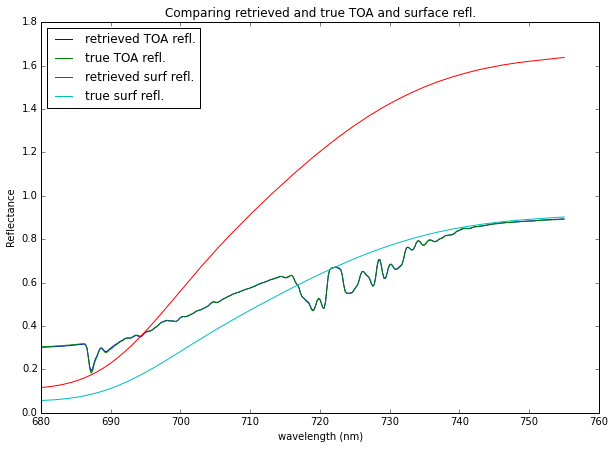

In [21]:
dic = pickle.load(open(fns[0], 'rb'))

# cloud fraction to use
clf = 0.3

# round to closest value
sza = dic['sol_zen']
vza = dic['sat_zen']
raa = dic['rel_azi']
alt = dic['alt']
AOT = dic['AOT']
WVC = dic['WVC']
press = dic['press']
a = dic['a']
p = dic['p']
szar = int(round(sza, -1))
vzar = int(round(vza, -1))
raas = range(0, 195, 15)
raar = min(raas, key=lambda x:abs(x-raa))
toa_refl = dic['toa_refl']
lam = dic['lam']

# get wavelength interval to approximately GOME-2 resolution
resol = 0.2 # in nm
lam_gome = np.arange(wl_min, wl_max+0.001, resol)
lam_gome[-1] = np.round(lam_gome[-1], 2) # get rid of precision error

# adding clouds
#import pandas as pd
#fn = 'cloud_sims.h5'
#cld_type = 'Cu'
#cld_df = pd.read_hdf(fn, key='reflectance')
#cld_lam = cld_df[cld_type].icol(0).index.values
#cld_ref = cld_df[cld_type].icol(0).values
#cld_ref = (interp1d(cld_lam, cld_ref, kind='linear'))(lam_gome)

# add the uncorrelated noise
# use convention of SNR = expected signal / std of noise
#snr = 1000 # see sources above
#std_noise = cld_ref / snr
#rand_noise = np.random.normal(0., std_noise)
#cld_ref += rand_noise

# refl to gome
toa_refl_gome = (interp1d(lam, toa_refl, kind='linear'))(lam_gome)
std_noise = toa_refl_gome / snr
rand_noise = np.random.normal(0., std_noise)
toa_refl_gome += rand_noise

# combine atmosphere and cloud signal
toa_refl_gome = toa_refl_gome * (1. - clf) + cld_ref * clf

# import cloud PCA
h5_fn = 'cloud_sims.h5'
pca_red_df = pd.read_hdf(h5_fn, key='pca_red_edge')

pca_lam = np.array(pca_red_df.index)
pcas_ = pca_red_df.values.T

# interpolate to gome resolution
pcas = []
for pc in pcas_:
    pcas.append((interp1d(pca_lam, pc, kind='linear'))(lam_gome))
pcas = np.array(pcas)

import gp_emulator
h5_emu = '/home/malapradej/Documents/PhD_UCL/Data/LUT/libradtran_emulators.h5'
emu = gp_emulator.MultivariateEmulator(dump=h5_emu, model='toa_refl', sza=szar, vza=vzar, raa=raar)

import h5py
h5_mean = h5py.File('/home/malapradej/Documents/PhD_UCL/Data/LUT/mean_signal.h5', 'r')
grp = '%s_%s_%s' % (szar, vzar, raar)
grp = h5_mean[grp]
mean_toa_refl = grp['mean_toa_refl'][:]

def cost(paras, sza, vza, raa, alt, toa_refl_gome, lam_gome, lam_emu, pcas):
    '''The cost function to minimize
    '''
    WVC = paras[0]
    AOT = paras[1]
    press = paras[2]
    a = paras[3]
    p = paras[4]
    a0 = paras[5]
    a1 = paras[6]
    paras = (WVC, AOT, alt, press, a, p)
    toa_refl_emu = emu.predict(paras)[0] + mean_toa_refl
    # get refls to same wavelenghts
    from scipy.interpolate import interp1d
    toa_refl_pred = (interp1d(lam_emu, toa_refl_emu, kind='linear'))(lam_gome)
    toa_refl_pred = 1. / a0 * (toa_refl_pred - a1 * pcas[0])
    rmse = np.sqrt(np.sum((toa_refl_pred - toa_refl_gome)**2.))
    return rmse

args = (szar, vzar, raar, alt, toa_refl_gome, lam_gome, lam, pcas)
#guess = (36., 0.5, 770., 0.4, 0.4, 1.1, 30.) # wvc, aot, press, a, p, a0, a1
guess = (20, 0.1, 1000, 0.5, 0.5, 1.3, 30.)
bounds = ((0., 80.), (0., 1.), (500., 1100.), (0., 1.), (0., 1.), (1., 1000), (0., 10000))
lower = (0., 0., 500., 0., 0., 1., 0.)
upper = (80., 1., 1100., 1., 1., 1000., 10000.)
solv_paras = optimize.minimize(cost,guess,jac=False,method='L-BFGS-B',\
                                args=args,bounds=bounds, options={'lower': lower, 'upper': upper})  

# show difference between retrieved and true parameters and plot retrieved and true spectra
WVCr = solv_paras['x'][0]
AOTr = solv_paras['x'][1]
pressr = solv_paras['x'][2]
ar = solv_paras['x'][3]
pr = solv_paras['x'][4]
a0r = solv_paras['x'][5]
clfr = (a0r - 1.) / a0r
a1r = solv_paras['x'][6]
rmse = solv_paras['fun']
succ = solv_paras['success']

surf_refl_fun = lambda a, p, w: a * w / (1. - p * w)
dasf_fun = lambda a, p: a / (1. - p)

dasf_true = dasf_fun(a, p)
dasf_pred = dasf_fun(ar, pr)

print 'solver success: %s' % succ
print 'rmse: %.4f' % rmse
print 'sza: %s, vza: %s, raa: %s, alt: %s km' % (sza, vza, raa, alt)
print '-'*50
print 'True parameters'
print 'clf: %5.4f, AOT: %5.4f, WVC: %7.4f kg/m2, press: %9.4f hPa, a: %5.4f, p: %5.4f, DASF: %5.4f' % \
        (clf, AOT, WVC, press, a, p, dasf_true)
print '-'*50
print 'Retrieved parameters'
print 'clf: %5.4f, AOT: %5.4f, WVC: %7.4f kg/m2, press: %9.4f hPa, a: %5.4f, p: %5.4f, DASF: %5.4f' % \
    (clfr, AOTr, WVCr, pressr, ar, pr, dasf_pred)
#print solv_paras

# plot the spectra true and retrieved
toa_refl_pred = emu.predict((WVCr, AOTr, alt, pressr, ar, pr))[0] + mean_toa_refl
toa_refl_pred = (interp1d(lam, toa_refl_pred, kind='linear'))(lam_gome)
toa_refl_pred = 1. / a0r * (toa_refl_pred - a1r * pcas[0])
plt.figure(figsize=(10,7))
plt.plot(lam_gome, toa_refl_pred, label='retrieved TOA refl.')
plt.plot(lam_gome, toa_refl_gome, label='true TOA refl.')
leafw = np.loadtxt('leaf_spectrum.txt')
lam_leaf = leafw[:,0]
leafw = leafw[:,1] + leafw[:,2]
w = (interp1d(lam_leaf, leafw, kind='linear'))(lam_gome)
surf_refl_retr = surf_refl_fun(ar, pr, w)
surf_refl = surf_refl_fun(a, p, w)
plt.plot(lam_gome, surf_refl_retr, label='retrieved surf refl.')
plt.plot(lam_gome, surf_refl, label='true surf refl.')
plt.title('Comparing retrieved and true TOA and surface refl.')
plt.legend(loc='best')
plt.xlabel('wavelength (nm)')
plt.ylabel('Reflectance')

there is a tendency due to the ill-posedness of the problem, for AOT to compensate for clf, with resulting lower clf and higher AOT. In certain cases the a parameter can also compensate for clf with lower clf and higher a values. The retrievals are not great, and this due to principally the ill-posedness of the problem. There are many possible solutions or parameter combinations that will give the same forward modelling results. The best way to overcome this is through the use of DA or a Bayesian framework where all available information can be used as a prior, together with knowledge of the observational uncertainties, to get a better posterior prediction of the parameter values. 

# The Bayesian framework

In [22]:
from scipy import optimize
import pickle
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

# load the filename list
#fns = glob.glob('../../Data/LUT/lhd300_validate_ap/20/30/45/*.p')
fns = ['../../Data/LUT/lhd1000_valid_ap_realistic/21_15_19_0.50970436_0.07229065_16.37942169_1001.99633933_0.36659157_0.624668.p']

print 'loading file: %s' % fns[0]


loading file: ../../Data/LUT/lhd1000_valid_ap_realistic/21_15_19_0.50970436_0.07229065_16.37942169_1001.99633933_0.36659157_0.624668.p


solver success: True
cost: 76.9411
sza: 21.0, vza: 15.0, raa: 19.0, alt: 0.50970436 km
--------------------------------------------------
True parameters
clf: 0.3000, AOT: 0.0723, WVC: 16.3794 kg/m2, press: 1001.9963 hPa, a: 0.3666, p: 0.6247, DASF: 0.9767
--------------------------------------------------
Prior parameters (mean, std)
clf: 0.2500, AOT: 0.1000, WVC: 20.0000 kg/m2, press: 1000.0000 hPa
std: 0.0500, std: 0.0500, std:  3.0000 kg/m2, std:      5.0000 hPa
--------------------------------------------------
Retrieved parameters (mean, std)
clf: 0.2673, AOT: 0.1076, WVC: 21.9899 kg/m2, press: 1014.7325 hPa, a: 0.3488, p: 0.6281, DASF: 0.9380
std: 0.0349, std: 0.0343, std:  0.2560 kg/m2, std:      3.4917 hPa,std:0.0168,std:0.0039
--------------------------------------------------
Correlation matrix
[[ 1.         -0.42201357 -0.11838762 -0.20088511  0.04688089 -0.18120195
  -0.15137482]
 [-0.42201357  1.          0.00455931  0.12076212 -0.29524519 -0.03839482
  -0.11481206]
 [-0.

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:129: OptimizeWarning: Unknown solver options: upper, lower


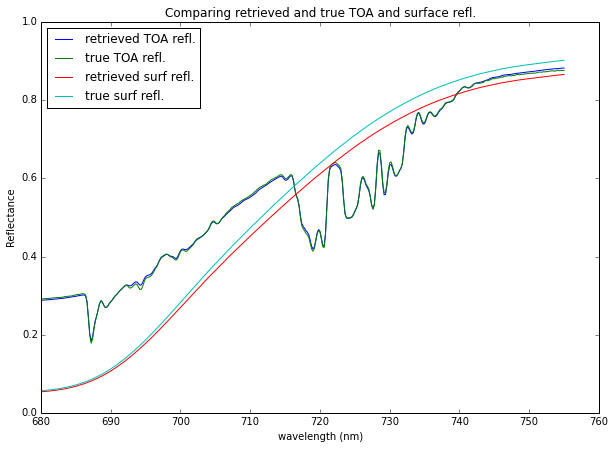

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


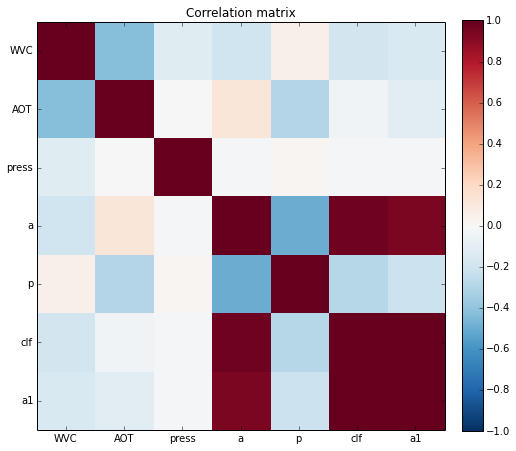

In [24]:
dic = pickle.load(open(fns[0], 'rb'))

# cloud fraction to use
clf = 0.3

# priors variances are based on the following:
# MODIS AOD +-0.05 +-0.2*tau (Chu et al. 2002)
# MODIS WV std 2.2mm (Li, Muller & Cross, 2003)
# NCEP press unknown...
# FRESCO vs FRESCO+ clf std 0.023 (Tuinder et al 2010) but expected accuracy <10% (Valks et al 2013)


AOT_prior = 0.10
AOT_var = (0.05)**2
WVC_prior = 20.
WVC_var = (3.0)**2
press_prior = 1000.
press_var = (5.0)**2
clf_prior = 0.25
clf_var = (0.05)**2

# round to closest value
sza = dic['sol_zen']
vza = dic['sat_zen']
raa = dic['rel_azi']
alt = dic['alt']
AOT = dic['AOT']
WVC = dic['WVC']
press = dic['press']
a = dic['a']
p = dic['p']
szar = int(round(sza, -1))
vzar = int(round(vza, -1))
raas = range(0, 195, 15)
raar = min(raas, key=lambda x:abs(x-raa))
toa_refl = dic['toa_refl']
lam = dic['lam']

# get wavelength interval to approximately GOME-2 resolution
resol = 0.2 # in nm
lam_gome = np.arange(wl_min, wl_max+0.001, resol)
lam_gome[-1] = np.round(lam_gome[-1], 2) # get rid of precision error

# adding clouds
import pandas as pd
fn = 'cloud_sims.h5'
cld_type = 'Cu'
cld_df = pd.read_hdf(fn, key='reflectance')
cld_lam = cld_df[cld_type].icol(0).index.values
cld_ref = cld_df[cld_type].icol(0).values
cld_ref = (interp1d(cld_lam, cld_ref, kind='linear'))(lam_gome)

# add the uncorrelated noise
# use convention of SNR = expected signal / std of noise
snr = 1000 # see sources above
std_noise = cld_ref / snr
rand_noise = np.random.normal(0., std_noise)
cld_ref += rand_noise

# refl to gome
toa_refl_gome = (interp1d(lam, toa_refl, kind='linear'))(lam_gome)
std_noise = toa_refl_gome / snr
rand_noise = np.random.normal(0., std_noise)
toa_refl_gome += rand_noise

# combine atmosphere and cloud signal
toa_refl_gome = toa_refl_gome * (1. - clf) + cld_ref * clf

# import cloud PCA
h5_fn = 'cloud_sims.h5'
pca_red_df = pd.read_hdf(h5_fn, key='pca_red_edge')

pca_lam = np.array(pca_red_df.index)
pcas_ = pca_red_df.values.T

# interpolate to gome resolution
pcas = []
for pc in pcas_:
    pcas.append((interp1d(pca_lam, pc, kind='linear'))(lam_gome))
pcas = np.array(pcas)

import gp_emulator
h5_emu = '/home/malapradej/Documents/PhD_UCL/Data/LUT/libradtran_emulators.h5'
emu = gp_emulator.MultivariateEmulator(dump=h5_emu, model='toa_refl', sza=szar, vza=vzar, raa=raar)

import h5py
h5_mean = h5py.File('/home/malapradej/Documents/PhD_UCL/Data/LUT/mean_signal.h5', 'r')
grp = '%s_%s_%s' % (szar, vzar, raar)
grp = h5_mean[grp]
mean_toa_refl = grp['mean_toa_refl'][:]

def cost(paras, sza, vza, raa, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVCe, WVCv, AOTe, AOTv,\
         presse, pressv, clfe, clfv):
    '''The cost function to minimize the log of the probabilities
    '''
    WVC = paras[0]
    AOT = paras[1]
    press = paras[2]
    a = paras[3]
    p = paras[4]
    clf = paras[5]
    a1 = paras[6]
    paras = (WVC, AOT, alt, press, a, p)
    toa_refl_emu = emu.predict(paras)[0] + mean_toa_refl
    # get refls to same wavelenghts
    from scipy.interpolate import interp1d
    toa_refl_pred = (interp1d(lam_emu, toa_refl_emu, kind='linear'))(lam_gome)
    a0 = 1. / (1. - clf)
    toa_refl_pred = 1. / a0 * (toa_refl_pred - a1 * pcas[0])
    # forward model J term. need to calculate variance
    modvar = (toa_refl_gome/snr)**2.
    Jmod = np.sum((toa_refl_pred - toa_refl_gome)**2./modvar)/len(toa_refl_pred)
    # WVC J term
    Jwvc = (WVC - WVCe)**2./WVCv
    # AOT J term
    Jaot = (AOT - AOTe)**2./AOTv
    # press J term
    Jpress = (press - presse)**2./pressv
    # clf J term
    Jclf = (clf - clfe)**2./clfv
    J = Jmod + Jwvc + Jaot + Jpress + Jclf
    return J

args = (szar, vzar, raar, alt, toa_refl_gome, lam_gome, lam, pcas, snr, WVC_prior, WVC_var, AOT_prior, AOT_var,\
         press_prior, press_var, clf_prior, clf_var)
#guess = (36., 0.5, 770., 0.4, 0.4, 1.1, 30.) # wvc, aot, press, a, p, clf, a1
guess = (WVC_prior, AOT_prior, press_prior, 0.5, 0.5, clf_prior, 30.)
bounds = ((0., 80.), (0., 1.), (500., 1100.), (0., 1.), (0., 1.), (0., 1.), (0., 10000))
lower = (0., 0., 500., 0., 0., 1., 0.)
upper = (80., 1., 1100., 1., 1., 1000., 10000.)
solv_paras = optimize.minimize(cost,guess,jac=False,method='L-BFGS-B',\
                                args=args,bounds=bounds, options={'lower': lower, 'upper': upper, 'maxiter': 1000})  

# show difference between retrieved and true parameters and plot retrieved and true spectra
WVCr = solv_paras['x'][0]
AOTr = solv_paras['x'][1]
pressr = solv_paras['x'][2]
ar = solv_paras['x'][3]
pr = solv_paras['x'][4]
clfr = solv_paras['x'][5]
a0r = 1. / (1. - clfr)
a1r = solv_paras['x'][6]
err = solv_paras['fun']
succ = solv_paras['success']

surf_refl_fun = lambda a, p, w: a * w / (1. - p * w)
dasf_fun = lambda a, p: a / (1. - p)

dasf_true = dasf_fun(a, p)
dasf_pred = dasf_fun(ar, pr)

# calculate the Hessian for the std of the posterior 
import numdifftools as nd
hes = nd.Hessian(cost, full_output=True)
x = (WVCr, AOTr, pressr, ar, pr, clfr, a1r)
args = (szar, vzar, raar, alt, toa_refl_gome, lam_gome, lam, pcas, snr, WVC_prior, WVC_var, AOT_prior, AOT_var,\
         press_prior, press_var, clf_prior, clf_var)
H = hes(x, szar, vzar, raar, alt, toa_refl_gome, lam_gome, lam, pcas, snr, WVC_prior, WVC_var, AOT_prior, AOT_var,\
         press_prior, press_var, clf_prior, clf_var)
Cov = np.linalg.inv(H[0])
post_std = np.sqrt(np.diag(Cov))
WVCs, AOTs, presss, ass, ps, clfs, a1s = post_std

# calculate the correlation matrix
D = np.eye(7)*np.sqrt ( Cov.diagonal() )
R = np.linalg.inv ( D )
corr =  R.dot(Cov.dot(R))

print 'solver success: %s' % succ
print 'cost: %.4f' % err
print 'sza: %s, vza: %s, raa: %s, alt: %s km' % (sza, vza, raa, alt)
print '-'*50
print 'True parameters'
print 'clf: %5.4f, AOT: %5.4f, WVC: %7.4f kg/m2, press: %9.4f hPa, a: %5.4f, p: %5.4f, DASF: %5.4f' % \
        (clf, AOT, WVC, press, a, p, dasf_true)
print '-'*50
print 'Prior parameters (mean, std)'
print 'clf: %5.4f, AOT: %5.4f, WVC: %7.4f kg/m2, press: %9.4f hPa' % \
        (clf_prior, AOT_prior, WVC_prior, press_prior,)
print 'std: %5.4f, std: %5.4f, std: %7.4f kg/m2, std:   %9.4f hPa' % \
        (np.sqrt(clf_var), np.sqrt(AOT_var), np.sqrt(WVC_var), np.sqrt(press_var))
print '-'*50
print 'Retrieved parameters (mean, std)'
print 'clf: %5.4f, AOT: %5.4f, WVC: %7.4f kg/m2, press: %9.4f hPa, a: %5.4f, p: %5.4f, DASF: %5.4f' % \
    (clfr, AOTr, WVCr, pressr, ar, pr, dasf_pred)
print 'std: %5.4f, std: %5.4f, std: %7.4f kg/m2, std:   %9.4f hPa,std:%5.4f,std:%5.4f' % \
        (clfs, AOTs, WVCs, presss, ass, ps )
print '-'*50
#print solv_paras

# plot the spectra true and retrieved
toa_refl_pred = emu.predict((WVCr, AOTr, alt, pressr, ar, pr))[0] + mean_toa_refl
toa_refl_pred = (interp1d(lam, toa_refl_pred, kind='linear'))(lam_gome)
toa_refl_pred = 1. / a0r * (toa_refl_pred - a1r * pcas[0])
plt.figure(figsize=(10,7))
plt.plot(lam_gome, toa_refl_pred, label='retrieved TOA refl.')
plt.plot(lam_gome, toa_refl_gome, label='true TOA refl.')
leafw = np.loadtxt('leaf_spectrum.txt')
lam_leaf = leafw[:,0]
leafw = leafw[:,1] + leafw[:,2]
w = (interp1d(lam_leaf, leafw, kind='linear'))(lam_gome)
surf_refl_retr = surf_refl_fun(ar, pr, w)
surf_refl = surf_refl_fun(a, p, w)
plt.plot(lam_gome, surf_refl_retr, label='retrieved surf refl.')
plt.plot(lam_gome, surf_refl, label='true surf refl.')
plt.title('Comparing retrieved and true TOA and surface refl.')
plt.legend(loc='best')
plt.xlabel('wavelength (nm)')
plt.ylabel('Reflectance')

# plot the correlation matrix and print values
plt.figure(figsize=(8,8))
plt.imshow(corr,interpolation='nearest', cmap=plt.cm.RdBu_r, vmax=1, vmin=-1)
plt.title('Correlation matrix')
plt.xticks(np.arange(0.,7.,1),['WVC', 'AOT', 'press', 'a', 'p', 'clf', 'a1'])
plt.yticks(np.arange(0.,7.,1),['WVC', 'AOT', 'press', 'a', 'p', 'clf', 'a1'])
plt.colorbar(fraction=0.046, pad=0.04)
print 'Correlation matrix'
print corr

In [25]:
lam

array([ 540.  ,  540.05,  540.1 , ...,  799.9 ,  799.95,  800.  ])